# Checkpoint 8: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones on `AEs`. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10AM Friday** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [1]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Keras import(s)
#if float(tf.__version__[:3])>2.8:
from tensorflow.keras.utils import plot_model
#from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import BatchNormalization,Input, Dense, Dropout, Flatten, Reshape, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Lambda, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

# Keras import(s)
if float(tf.__version__[:3])>2.8:
    from tensorflow.keras.utils import plot_model
else:
    from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [3]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

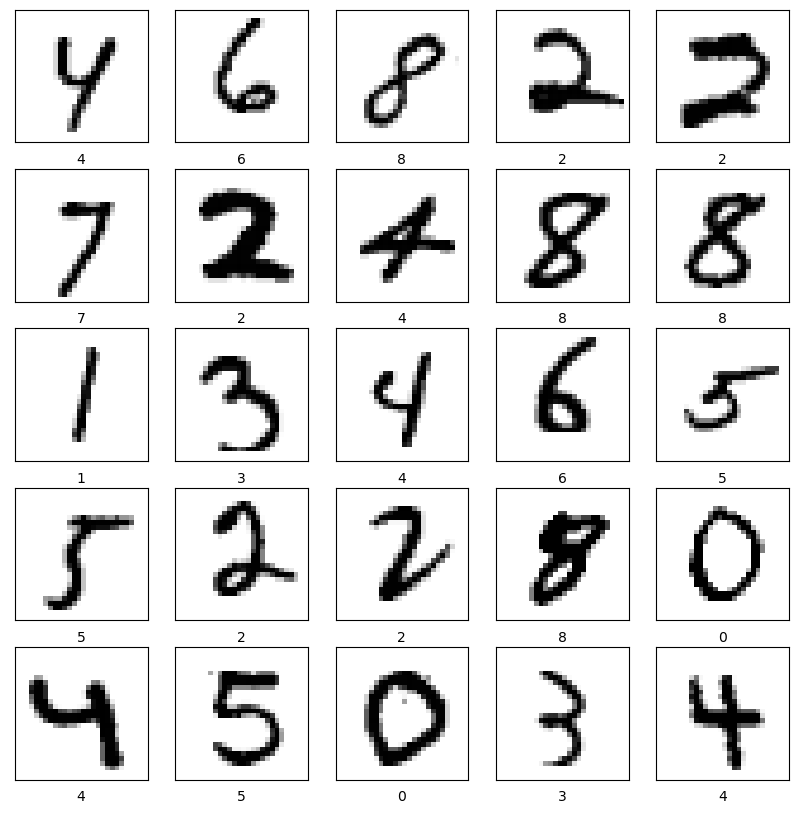

label marks [4 6 8 2 2 7 2 4 8 8 1 3 4 6 5 5 2 2 8 0 4 5 0 3 4]


In [4]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [5]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [6]:
#Encoder
intermediate_dim =256         #Define number of nodes in hidden layers
latent_dim = 2

inputs = Input(shape=(28,28,1))    #Input layer with shape of image
x = inputs

#1,2,4,8,16 filter convolution used
x = Conv2D(1, kernel_size=(3,3), padding='same', activation='relu')(x)  
x = MaxPooling2D(pool_size=(2,2))(x)              #reduce spatial dimentions on output volume with pooling
x = Conv2D( 2, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D( 4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D( 8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D( 16, kernel_size=(3,3), padding='same', activation='relu')(x)

x = Flatten()(x)                                 #Unstack tensor values into 1d array so can apply dense layers
x = Dense(intermediate_dim, activation = "relu")(x)
x = Dense(intermediate_dim, activation = "relu")(x)
x = Dense(intermediate_dim, activation = "relu")(x)




z_mean = Dense(latent_dim, name="z_mean")(x)            #define z_mean to contain means of latent space pdf for a given image
z_log_var = Dense(latent_dim, name="z_log_var")(x)      #define z_log_var which contains the logarithm of the associated variances
z= Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean,z_log_var])   #Call sampling function 
#z = sampling([z_mean,z_log_var])
encoder = Model(inputs, outputs = [z_mean, z_log_var, z],  name='encoder')    #Build the model
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 1)    10          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 1)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 2)    20          ['max_pooling2d[0][0]']          
                                                                                            

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [7]:
#Decoder


latent_inputs = Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='relu')(x)
x = Dense(7*7*16,activation = 'relu')(x)  #Apply dense layer with dimensionality 784 

x = Reshape((7,7,16))(x)       #Reshape in order to apply convolution layers
#Mirror encoder layers with 16-8-4-2-1 convolution layers.
x = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(2, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(1, kernel_size=(3,3), padding='same', activation='sigmoid')(x)



x = Reshape(shape)(x)                             #Reshape to image shape
decoder = Model(latent_inputs, x, name='decoder') #Build model
decoder.summary()







Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 16)          2320      
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 16)       0   

#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

Model: "ConvAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               335142    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         271913    
                                                                 
Total params: 607,055
Trainable params: 607,055
Non-trainable params: 0
_________________________________________________________________




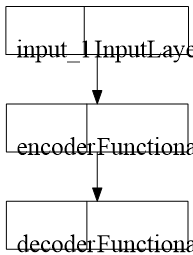

In [8]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
    i = i[0]
    pass
z = encoder(i)[2]
o = decoder(z)
vae = Model(i, o, name='ConvAE')
vae.summary()
plot_model(vae)

# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [9]:
def compile_vae(vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Compile the model.
* Train for ca. **50 epochs**.
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation

In [10]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

In [11]:
compile_vae(vae)      #Call compiler function

#Train model with X_train data. A validation split of 0.2 (20%) is used, and the data is shuffled in each iteration
history = vae.fit(X_train,X_train, epochs=nb_epochs, batch_size=128,validation_split=0.2,shuffle=True)




Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - ETA: 0s - loss: 216.8356 - reco_loss: 214.5776 - kl_loss: 2.2579

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 24s 495us/sample - loss: 216.8356 - reco_loss: 214.5776 - kl_loss: 2.2579 - val_loss: 179.6542 - val_reco_loss: 175.7930 - val_kl_loss: 3.8612
Epoch 2/50
48000/48000 [==============================] - 32s 663us/sample - loss: 171.9849 - reco_loss: 167.4698 - kl_loss: 4.5151 - val_loss: 166.3496 - val_reco_loss: 161.3550 - val_kl_loss: 4.9945
Epoch 3/50
48000/48000 [==============================] - 29s 596us/sample - loss: 162.3752 - reco_loss: 157.1610 - kl_loss: 5.2142 - val_loss: 158.3418 - val_reco_loss: 152.9765 - val_kl_loss: 5.3654
Epoch 4/50
48000/48000 [==============================] - 37s 773us/sample - loss: 156.6824 - reco_loss: 151.1411 - kl_loss: 5.5413 - val_loss: 155.7613 - val_reco_loss: 150.0379 - val_kl_loss: 5.7235
Epoch 5/50
48000/48000 [==============================] - 33s 693us/sample - loss: 153.7238 - reco_loss: 148.0192 - kl_loss: 5.7047 - val_loss: 152.0763 - val_reco_loss: 146.1909 - val_kl_loss: 5.8853
Epoch 

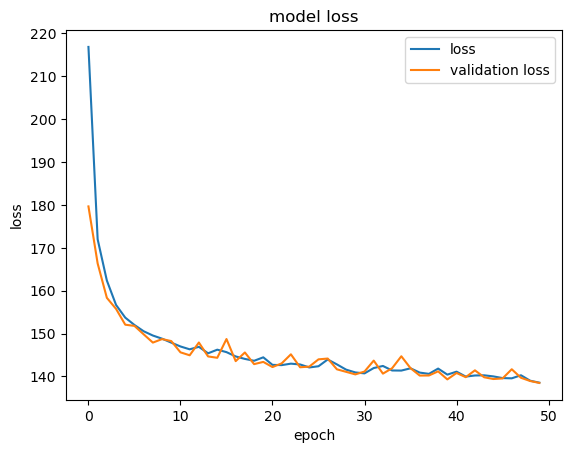

In [12]:
fig,ax = plt.subplots()

#Plot loss curves
ax.plot(history.history['loss'], label = "loss")
ax.plot(history.history['val_loss'], label = "validation loss")

ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title('model loss')
ax.legend(["loss","validation loss"])



Here we can see that the model has been effective. This is because the validation loss  curve roughly follows the loss curve meaning that the model is neither under- or overtraining on the training data. If it were overtraining, we would see the the validation loss much higher than the training loss. If it were undertrained the loss curves would not decrease significantly.

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


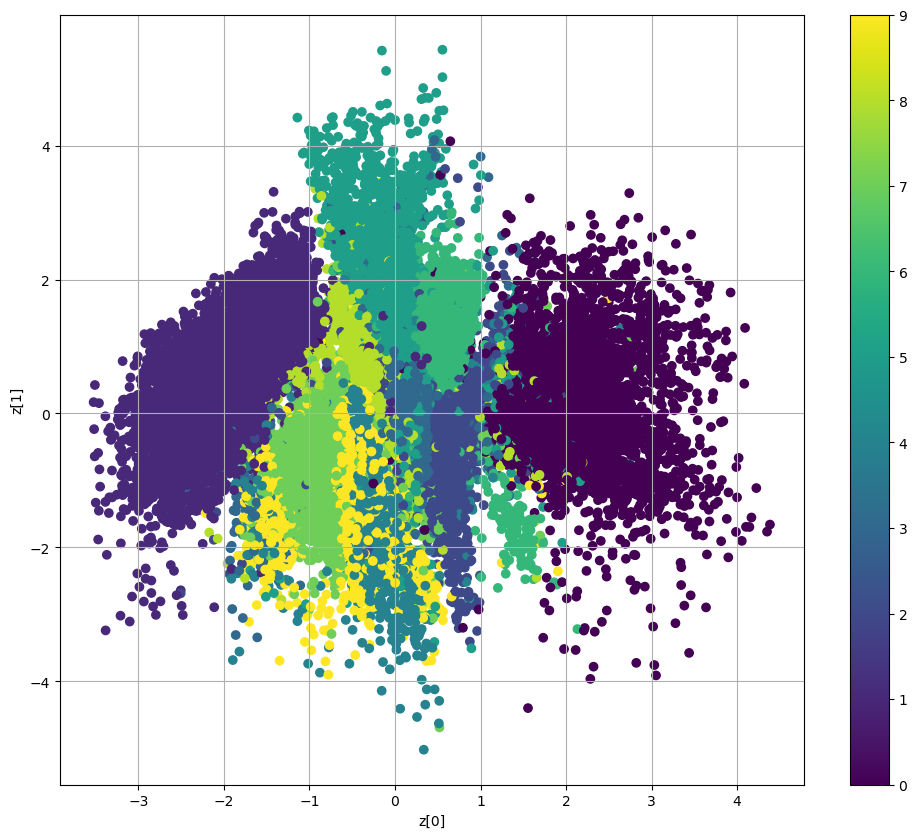

In [13]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,cmap = 'viridis')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.grid()
    plt.show()


(X_train, y_train), _ = keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1).astype("float32") / 255


plot_label_clusters(vae, X_train, y_train)



There are clearly separate regions for the different labels, however there is overlap. There is significant overlap between the digits 5,7 and 9. This is because they have similar features, for example with 5 and 9 they both have a similar curly tail. The region containing mostly the digit 1 has relatively few overlaps since 1 is quite a unique shape as a straight line.

In [14]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    xx,yy = np.meshgrid(grid_x,grid_y)                      #Create meshgrid from the two linearly spaced arrays
    z_sample =(np.array([xx.ravel(), yy.ravel()]).T)        #flatten meshgrid in order to get decoder predictions
    x_decoded = decoder.predict(z_sample)                   #Call decoder to get predictions
   
    count = 0

    digit = x_decoded.reshape(900,digit_size,digit_size)
    
    #Iterates through x and y components in plot and appends pixel values
    for i in range(len(grid_y)):
        for j in range(len(grid_x)):
          
            
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
        
            ] = digit[count]
            count+=1
  
    
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure,cmap="Greys_r")
    plt.show()


#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

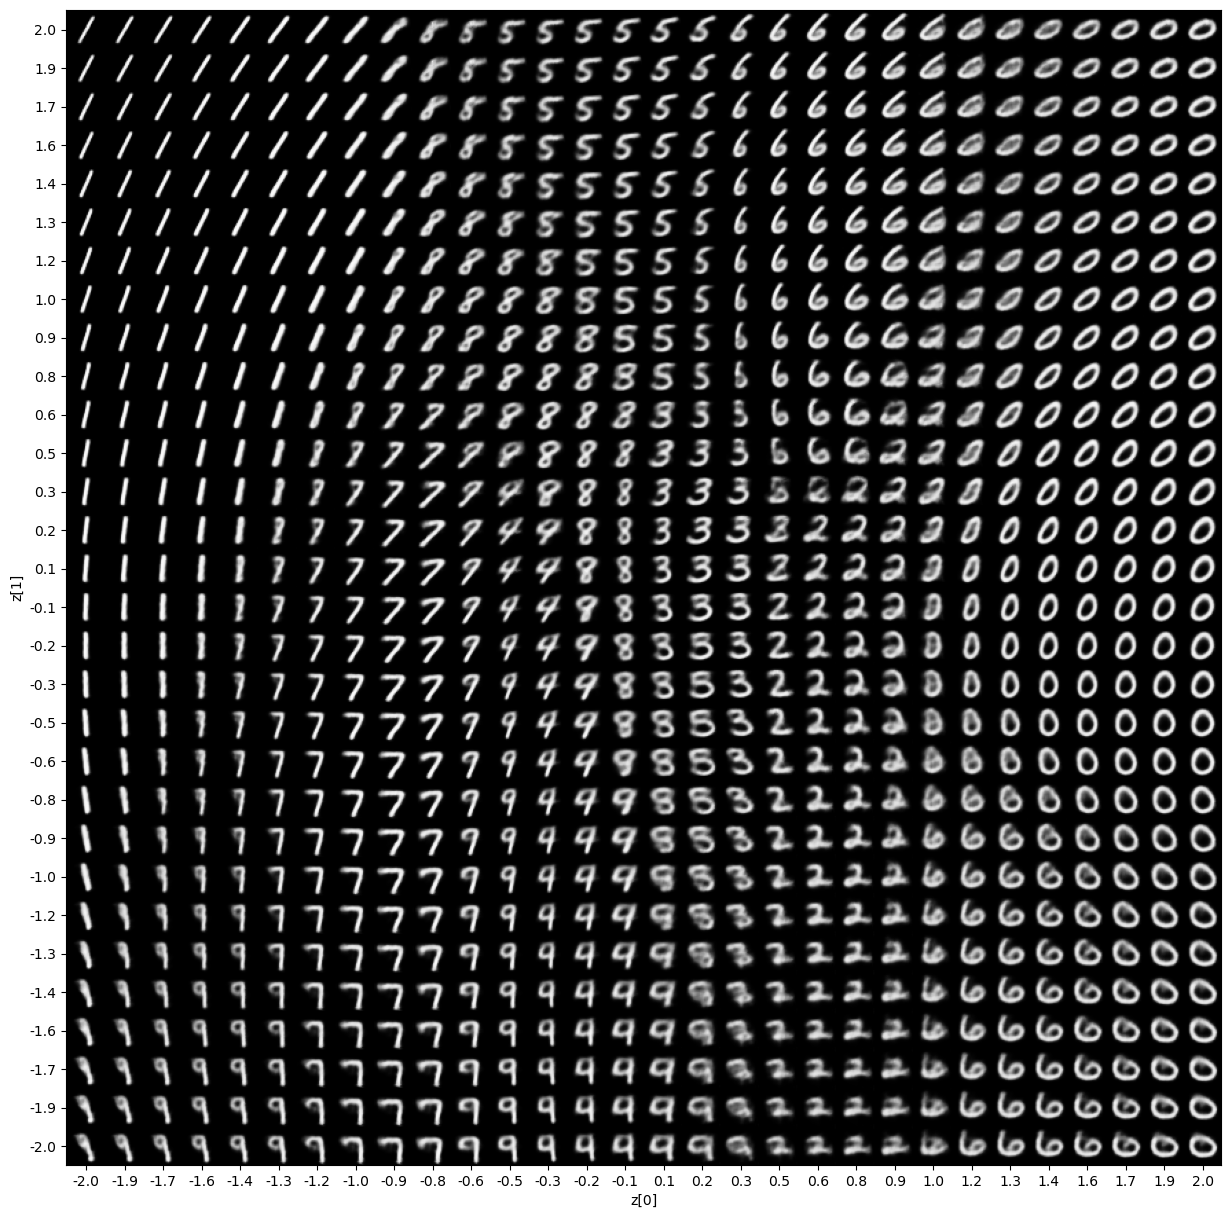

In [15]:

plot_latent_space(vae)

An equally spaced set of points along the latent space is used for the decoder to generate images. These images are plotted in a grid to allow us to observe the regions of digits and how they merge into each other at the digit region boundaries. SImilar to the scatter plot, there is overlap where numbers have similar features and the geometric shape of the digits may be similar, for example with 4 and 9.

# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [16]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
 

---

- Defined is the discriminator model using the `Sequential` keras function
    - What is the purpose of the discriminator?
    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    - Why is binary crossentropy used as the loss function?
    
---

-The discriminator here is a classifier which tries to distinguish the real data from the generated  data which guides the generator to produce more realistic images. It is a form of binary classification.
-The discriminator has two convolutional layers each with 64 filters, a kernel size of 3 and aa stride of 2. It has a single node in the output layer with sigmoid activation function since the problem is binary classification , to predict whether the input image is real or fake. The model has no pooling layers.

The dropout layer randomly sets input units to 0 at a set frequency at each step during training time. This helps to stop the model overfitting. The sum over all the inputs remains unchanged because the non-zero inputs are scaled to compensate. LeakyRELUs allow a small negative value to pass through so the function computes the greatest value between the features and a small factor, larger negative values are replaced with zero. This allows the netweork to train faster.

-Binary crossentropy is used because this is binary classification, the model is predicting whether the image is real or fake. In this model we have a single output node with sigmoid activation 



In [17]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


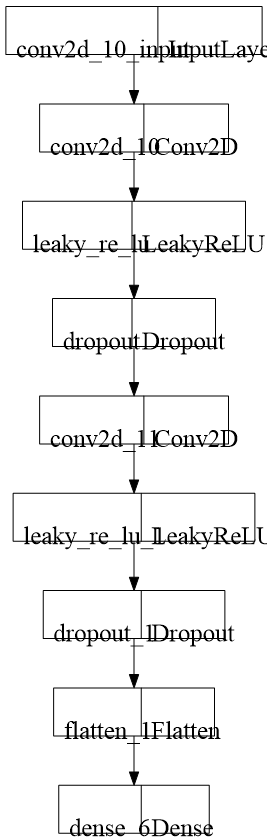

In [18]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?
    - What is the Conv2DTranspose layer used for?
    - Why is sigmoid used as the activation function?
    
---

-The generator takes a point from the latent space as input. This latent space is a vector space of Gaussian-distributed values which are drawn from randomly.
-The COnv2DTranspose layer upsamples the image to a higher-resolution version of the image. It combines Upsampling2D and Conv2D layers. The (2,2) stride quadruples the area of the inut feature maps and a kernel size of (4,4) is double the stride in order to avoid a checkerboard pattern when upsampling.
-Sigmoid activation function is used so that the output values are in the range [0,1] 



In [19]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

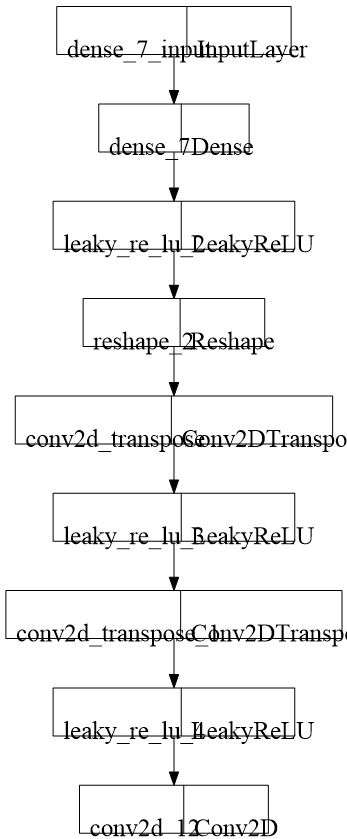

In [20]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.
    
---

- The Generator is fed random numbers from latent space and it generates an image. The image is given to the discriminator along with some images taken from a real dataset. The discriminator considers the images and gives a probability as to whether the image is real or fake. The weights of the generator are then updated depending on the performance of the discriminator.
- We do not want the discriminator to be affected when training the GAN. This is because it would then be overtrained in the fake images

In [21]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential (Sequential)     (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________




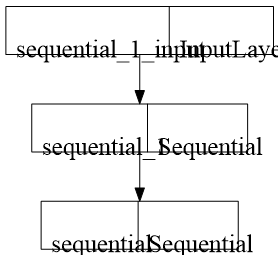

In [22]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for barch training
    - what is this data used for?
    - what is the `y = ones((n_samples, 1))` varible used for?
    
---

-This dataset contains the real samples which are the real images. This is fed to the discriminator alonside the fake generated images. 
- The 'y = ones((n_samples, 1))' variable returns an array of ones which are class labels for the sample, this classifies the images as real since this data is used for the real images

In [23]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.

In [24]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

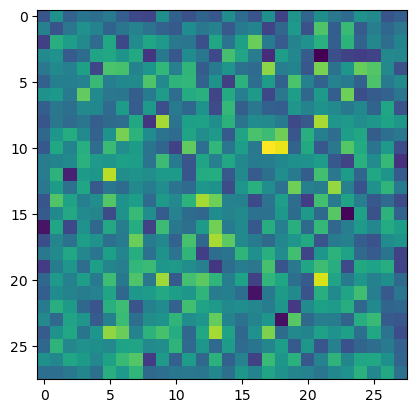

In [25]:
#Here the 

latent_dim = 100
model = define_generator(latent_dim)     
X,y = generate_fake_samples(model,latent_dim, n_samples = 1)
plt.imshow(X[0,:,:,0])

The image does not resemble any of the numbers since it has only gone through the generator and not the discriminator. Therefore it is Gaussian distributed random numbers from the latent space.

---
Some functions for saving GAN models and output images

In [26]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context. 


---

-The first line gets randomly selected real image data from the data set and class labels of 1 to represent real images
- The second line generates the fake images and class labels of 0 to represent fake images
-The next line stacks the real and fake image data to be used as the input for the discriminator 
-The next line updates the loss for the discriminator model
-Then the generate_letent_points function is called in order to create points in the latent space to be used as the input for the generator. These are random points in Gaussian distribution.
- The next line creates an array of class labels. When training on the GAN model, we want the discriminator to think that the generator images are real, so they are marked with class label "1" corresponding to real images.
-Finally the generator loss is updated using the performane of the discriminator.


The Discriminator is trained on the real and fake data and the loss values are updated. Then the latent points are created to be used as inputs for the generator. The discriminator is fed fake exmples from generator mixed with real data. The generator is updated via discriminator's error.



In [27]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have a GPU or some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

In [ ]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d=0.688, g=0.732
>1, 2/234, d=0.675, g=0.753
>1, 3/234, d=0.673, g=0.776
>1, 4/234, d=0.658, g=0.794
>1, 5/234, d=0.654, g=0.808
>1, 6/234, d=0.645, g=0.828
>1, 7/234, d=0.643, g=0.842
>1, 8/234, d=0.631, g=0.855
>1, 9/234, d=0.630, g=0.857
>1, 10/234, d=0.631, g=0.851
>1, 11/234, d=0.631, g=0.834
>1, 12/234, d=0.639, g=0.805
>1, 13/234, d=0.645, g=0.779
>1, 14/234, d=0.646, g=0.756
>1, 15/234, d=0.650, g=0.739
>1, 16/234, d=0.647, g=0.726
>1, 17/234, d=0.641, g=0.717
>1, 18/234, d=0.641, g=0.712
>1, 19/234, d=0.630, g=0.708
>1, 20/234, d=0.626, g=0.705
>1, 21/234, d=0.621, g=0.704
>1, 22/234, d=0.615, g=0.702
>1, 23/234, d=0.608, g=0.702
>1, 24/234, d=0.596, g=0.702
>1, 25/234, d=0.594, g=0.702
>1, 26/234, d=0.585, g=0.702
>1, 27/234, d=0.576, g=0.703
>1, 28/234, d=0.571, g=0.703
>1, 29/234, d=0.556, g=0.704
>1, 30/234, d=0.551, g=0.705
>1, 31/234, d=0.541, g=0.706
>1, 32/234, d=0.530, g=0.707
>1, 33/234, d=0.520, g=0.708
>1, 34/234, d=0.509, g=0.709
>1, 35/234, d=0.502, g=

>2, 40/234, d=0.616, g=0.718
>2, 41/234, d=0.617, g=0.755
>2, 42/234, d=0.607, g=0.720
>2, 43/234, d=0.594, g=0.743
>2, 44/234, d=0.598, g=0.757
>2, 45/234, d=0.589, g=0.742
>2, 46/234, d=0.601, g=0.759
>2, 47/234, d=0.582, g=0.745
>2, 48/234, d=0.603, g=0.764
>2, 49/234, d=0.603, g=0.767
>2, 50/234, d=0.647, g=0.781
>2, 51/234, d=0.635, g=0.773
>2, 52/234, d=0.674, g=0.784
>2, 53/234, d=0.701, g=0.838
>2, 54/234, d=0.701, g=0.891
>2, 55/234, d=0.704, g=0.949
>2, 56/234, d=0.698, g=1.017
>2, 57/234, d=0.712, g=1.033
>2, 58/234, d=0.716, g=1.032
>2, 59/234, d=0.732, g=1.008
>2, 60/234, d=0.738, g=0.977
>2, 61/234, d=0.721, g=0.942
>2, 62/234, d=0.749, g=0.848
>2, 63/234, d=0.733, g=0.830
>2, 64/234, d=0.778, g=0.798
>2, 65/234, d=0.743, g=0.748
>2, 66/234, d=0.767, g=0.701
>2, 67/234, d=0.751, g=0.698
>2, 68/234, d=0.729, g=0.677
>2, 69/234, d=0.747, g=0.662
>2, 70/234, d=0.749, g=0.660
>2, 71/234, d=0.735, g=0.650
>2, 72/234, d=0.732, g=0.629
>2, 73/234, d=0.739, g=0.626
>2, 74/234, d=

In [ ]:
summarize_performance(5, g_model, d_model, dataset, latent_dim,n_samples = 100)

Here the model is tested with n_samples = 100 generated images.The summary gives the accuracy that the model could distinguish real images and the accuracy with which the model could distinguish the fake images.

In the training we observe that the loss for the discriminator and generator fluctuates but generally in this case stays roughly constant; it very slightly decreases.

In [ ]:

# generate images
latent_points = generate_latent_points(100, 25)                #100 latent points in latent space
X,y = generate_fake_samples(g_model,latent_dim, n_samples = 1) #Use generator model to generate fake image
plt.imshow(X[0,:,:,0])